In [18]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import os
import json

In [2]:
# Data dir
data_dir = "L5_data"

# Input raster
fp = os.path.join(data_dir, "p188r018_7t20020529_z34__LV-FIN.tif")

# Output raster
out_tif = os.path.join(data_dir, "Helsinki_Masked.tif")

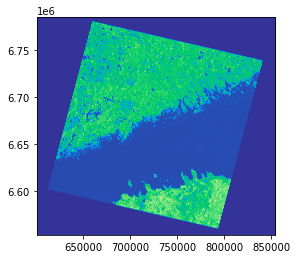

In [3]:
# Read the data
data = rasterio.open(fp)

# Visualize the NIR band
show((data, 4), cmap='terrain')

In [4]:
# WGS84 coordinates
minx, miny = 24.60, 60.00
maxx, maxy = 25.22, 60.35
bbox = box(minx, miny, maxx, maxy)

In [16]:
# Create a GeoDataFrame from the bounding box
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
print(geo)

                                            geometry
0  POLYGON ((25.22000 60.00000, 25.22000 60.35000...


/home/flycher/anaconda3/envs/gis/lib/python3.8/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [17]:
# Project the Polygon into same CRS as the grid
geo = geo.to_crs(crs=data.crs.data)

# Print crs
geo.crs

/home/flycher/anaconda3/envs/gis/lib/python3.8/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<Projected CRS: EPSG:32634>
Name: WGS 84 / UTM zone 34N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 18°E to 24°E - by country
- bounds: (18.0, 0.0, 24.0, 84.0)
Coordinate Operation:
- name: UTM zone 34N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [20]:
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[735275.3533476054, 6658919.843253607], [732783.5561207401, 6697846.086795722], [698608.1329965618, 6695816.080575279], [700733.5832412266, 6656875.248540204], [735275.3533476054, 6658919.843253607]]]}]


In [21]:
# Clip the raster with Polygon
out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

In [22]:
# Copy the metadata
out_meta = data.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 8877, 'height': 8106, 'count': 7, 'crs': CRS.from_epsg(32634), 'transform': Affine(28.5, 0.0, 600466.5,
       0.0, -28.5, 6784966.5)}


In [23]:
# Parse EPSG code
epsg_code = int(data.crs.data['init'][5:])
print(epsg_code)

32634


In [29]:
out_meta.update({
    "driver": "GTiff",
     "height": out_img.shape[1],
     "width": out_img.shape[2],
     "transform": out_transform,
     "crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs "
})

In [30]:
with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)